In [72]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import skimage as ski
import PIL.Image as Image
from PIL import ImageChops
import os


In [74]:

with rio.open(f'{basedir}data/raw/Orthomosaico_roi.tif') as src:
    img_array = src.read()
    profile = src.profile  
    img_rgb_reshaped = np.transpose(img_array, (1, 2, 0))



In [75]:

def resize_image_pil(img_array, width):
    img = Image.fromarray(img_array.astype(np.uint8))
    height = int((img.height / img.width) * width)
    img = img.resize((width, height))
    return np.array(img)


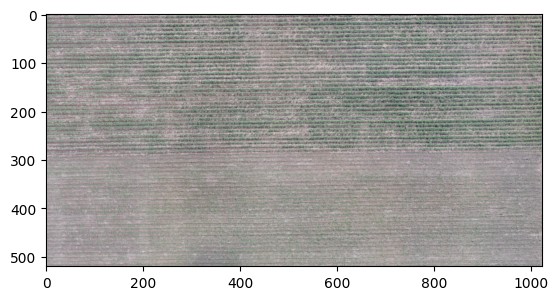

In [80]:
res_image = resize_image_pil(img_rgb_reshaped, 1024)    
Image.fromarray(res_image).save(f'{basedir}data/raw/Orthomosaico_roi.png')
plt.imshow(res_image, vmin=0, vmax=255)
plt.show()

Text(0, 0.5, 'Pixel count')

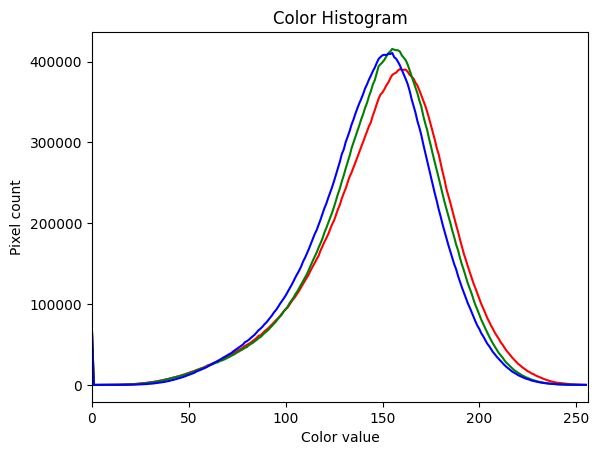

In [19]:
fig, ax = plt.subplots()
ax.set_xlim([0, 256])
for channel_id, color in enumerate(['red', 'green', 'blue']):
    histogram, bin_edges = np.histogram(
        img_rgb_reshaped[:, :, channel_id], bins=256, range=(0, 256)
    )
    ax.plot(bin_edges[0:-1], histogram, color=color)

ax.set_title("Color Histogram")
ax.set_xlabel("Color value")
ax.set_ylabel("Pixel count")

In [40]:
def calculate_exg(img_array):
    r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]
    exg = 2 * g - r - b
    threshold_for_binarization = ski.filters.threshold_mean(exg)
    #threshold_for_binarization = ski.filters.threshold_local(exg, block_size=223, offset=0)
    exg = exg > threshold_for_binarization
    print(np.unique(exg, return_counts=True))
    return ~exg

def calculate_gli(img_array):
    img_array = img_array.astype(np.float32)
    r, g, b = img_array[:, :, 0], img_array[:, :, 1], img_array[:, :, 2]
    numerator = 2 * g - r - b
    denominator = (2 * g + r + b)
    gli = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator != 0)
    gli = np.where(gli > 0, 1, 0)
    gli_norm = gli.astype(np.uint8)
    return gli_norm

(array([False,  True]), array([12194146, 16950482]))


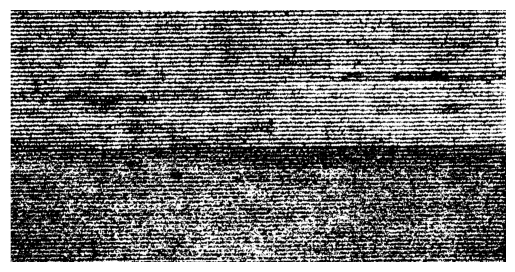

In [166]:
mask_exg = calculate_exg(img_rgb_reshaped)
plt.imshow(mask_exg, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

(array([0, 1], dtype=uint8), array([17525505, 11619123]))


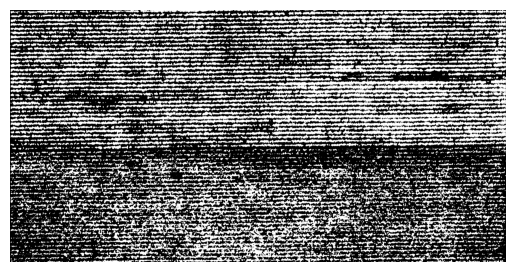

In [82]:
mask_gli = calculate_gli(img_rgb_reshaped)
print(np.unique(mask_gli, return_counts=True))
mask_gray = (mask_gli * 255).astype(np.uint8)
mask_gray_red = resize_image_pil(mask_gray, 1024)
Image.fromarray(mask_gray_red).save(f'{basedir}data/processed/mask_gli_gt.png')
plt.imshow(mask_gli, cmap='gray', vmin=0, vmax=1)
plt.axis('off')
plt.show()

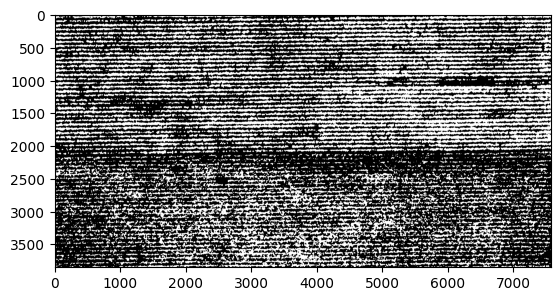

In [38]:
with rio.open(f'{basedir}test_mask/mask_example.tif') as src:
    mask_array = src.read()
    profile = src.profile
    mask_reshaped = np.transpose(mask_array, (1, 2, 0))
    mask_reshaped_tiled = mask_reshaped.reshape(mask_reshaped.shape[0], mask_reshaped.shape[1])
    Image.fromarray(mask_reshaped_tiled *).save(f'{basedir}test_mask/mask_example.png')
    plt.imshow(mask_reshaped, cmap='gray')
    plt.show()

Text(0.5, 1.0, 'Difference mask')

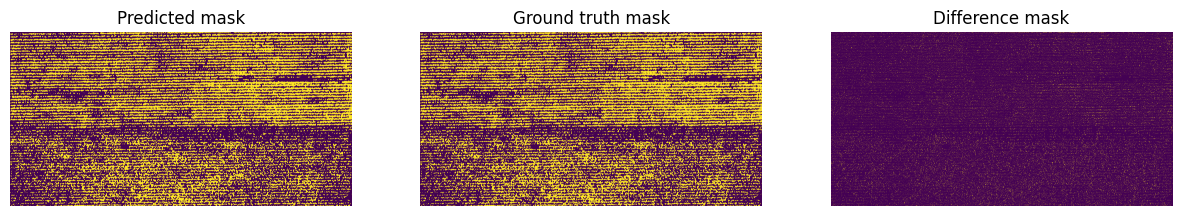

In [55]:
pred_mask = Image.open(f'{basedir}test_mask/mask_example.png')
gt_mask = Image.open(f'{basedir}data/processed/mask_gli_gt.png')
diff_mask = ImageChops.difference(pred_mask, gt_mask)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(pred_mask)
ax[1].imshow(gt_mask)
ax[2].imshow(diff_mask)
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[0].set_title('Predicted mask')
ax[1].set_title('Ground truth mask')
ax[2].set_title('Difference mask')
